# Imports Necessary Module

In [10]:
import os
import numpy as np
from skimage import io, color
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
import joblib

# Function for Loading and Preprocess Images

In [11]:
img_size = (1300, 650)



def load_and_preprocess_images(folder, img_size):
    images = []
    labels = []
    for subdir, _, files in os.walk(folder):
        label = subdir.split('\\')[-1]  
        for file in files:
            img_path = os.path.join(subdir, file)
            img = io.imread(img_path ,as_gray=True)  
            img_resized = resize(img, img_size, mode='reflect') 
            img_flattened = img_resized.flatten()  
            images.append(img_flattened)
            labels.append(label)
    return np.array(images), np.array(labels)
    

# Data Paths

In [12]:
train_folder = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\train"
valid_folder = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\val"
test_folder = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test"

# Loading and Preprocessing Image Data for Training, Validation, and Testing Sets

In [13]:
X_train, y_train = load_and_preprocess_images(train_folder, img_size)
X_valid, y_valid = load_and_preprocess_images(valid_folder, img_size)
X_test, y_test = load_and_preprocess_images(test_folder, img_size)

# Number of Images in each Class (Train, Validation, Test)

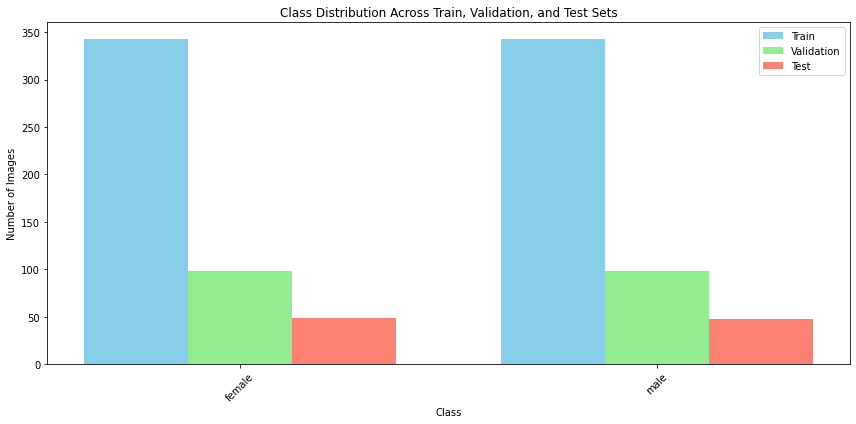

In [14]:
train_class_counts = Counter(y_train)
valid_class_counts = Counter(y_valid)
test_class_counts = Counter(y_test)

labels = sorted(set(y_train) | set(y_valid) | set(y_test))  
train_counts = [train_class_counts.get(label, 0) for label in labels]
valid_counts = [valid_class_counts.get(label, 0) for label in labels]
test_counts = [test_class_counts.get(label, 0) for label in labels]

x = np.arange(len(labels)) 
width = 0.25 

plt.figure(figsize=(12, 6))
plt.bar(x - width, train_counts, width, label='Train', color='skyblue')
plt.bar(x, valid_counts, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_counts, width, label='Test', color='salmon')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution Across Train, Validation, and Test Sets')
plt.xticks(x, labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Data Shapes

In [15]:
print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (686, 845000)
X_valid shape: (196, 845000)
X_test shape: (97, 845000)


# Displaying Randomly Selected Images with Labels

Displaying images from the training set:


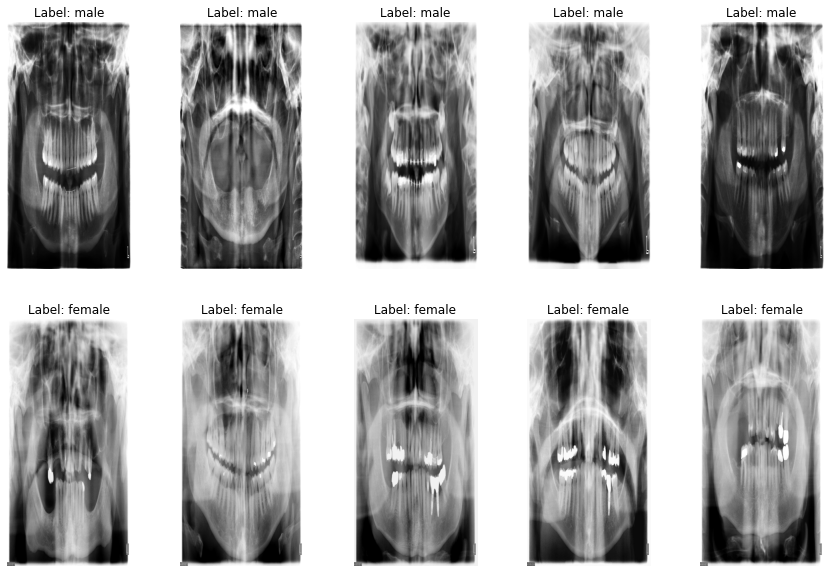

In [16]:
def display_images(images, labels, num_images=5):
    unique_labels = list(set(labels))  
    fig, axes = plt.subplots(len(unique_labels), num_images, figsize=(15, len(unique_labels) * 5))
    
    for i, label in enumerate(unique_labels):
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        
        for j in range(num_images):
            if j < len(label_images):
                ax = axes[i, j]
                ax.imshow(label_images[j].reshape(img_size[0], img_size[1]), cmap='gray', vmin=0, vmax=1)
                ax.set_title(f"Label: {label}")
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    plt.show()
print("Displaying images from the training set:")
display_images(X_train, y_train)


# Feature Scaling Using StandardScaler

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Encoding Labels Using LabelEncode

In [18]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_valid_encoded = encoder.transform(y_valid)
y_test_encoded = encoder.transform(y_test)

# First 5 Labels after encoding

In [19]:
print("First 10 values in y_train_encoded:")
print(y_train_encoded[:5])  

First 10 values in y_train_encoded:
[0 0 0 0 0]


# Combining Training and Validation Datasets for Cross Validation

In [20]:
X_combined = np.concatenate((X_train_scaled, X_valid_scaled), axis=0)
y_combined = np.concatenate((y_train_encoded, y_valid_encoded), axis=0)

# Support Vector Classification with 5-Fold Cross-Validation

In [21]:
model = SVC(kernel='linear', C=1.0) 
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_combined, y_combined, cv=kf, scoring='accuracy')

# Accuracy Scores for each Fold as well as the Mean Accuracy across All Folds

In [22]:
print(f'Cross-validation scores: {cv_scores}')
print(f'mean accuracy: {cv_scores.mean() * 100:.2f}%')

Cross-validation scores: [0.97740113 0.97740113 0.98295455 0.99431818 0.98863636]
mean accuracy: 98.41%


# Evaluating Accuracy on Test Data

In [23]:
model.fit(X_combined, y_combined)
test_accuracy = model.score(X_test_scaled, y_test_encoded) 
print(f'test accuracy: {test_accuracy * 100:.2f}%')

test accuracy: 96.91%


# Saving Model Artifacts: Label Encoder, Scaler, and SVM Model 

In [24]:
joblib.dump(encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(model, 'svm_model.pkl')

['svm_model.pkl']

# Classification Report

In [25]:
y_test_pred = model.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_test_pred, target_names=encoder.classes_))



Classification Report:
              precision    recall  f1-score   support

      female       0.98      0.96      0.97        49
        male       0.96      0.98      0.97        48

    accuracy                           0.97        97
   macro avg       0.97      0.97      0.97        97
weighted avg       0.97      0.97      0.97        97



# Confusion Matrix


Confusion Matrix:


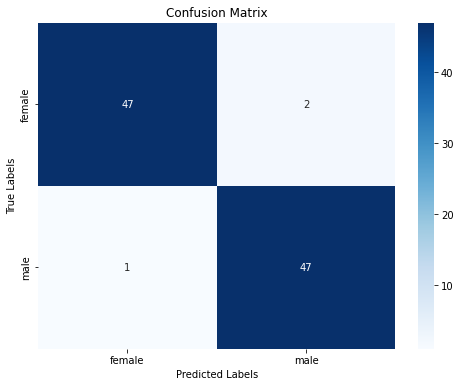

In [26]:
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# #  Load Trained Model and Predict Gender Class from a New Image

Predicted label: female


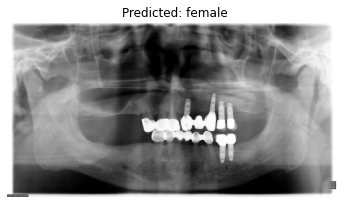

In [27]:
def preprocess_single_image(image_path, img_size):
    img = io.imread(image_path)  
    if len(img.shape) == 3:  
        img = color.rgb2gray(img)  
    img_resized = resize(img, img_size, mode='reflect') 
    img_flattened = img_resized.flatten()  
    return np.array([img_flattened])  

model_loaded = joblib.load('svm_model.pkl')
scaler_loaded = joblib.load('scaler.pkl')
encoder_loaded = joblib.load('label_encoder.pkl')

image_path = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test\\female\\female.442.JPG"
image_preprocessed = preprocess_single_image(image_path, img_size)

image_scaled = scaler_loaded.transform(image_preprocessed)
predicted_label_encoded = model_loaded.predict(image_scaled)
predicted_label = encoder_loaded.inverse_transform(predicted_label_encoded)

print(f'Predicted label: {predicted_label[0]}')
plt.imshow(io.imread(image_path), cmap='gray')
plt.title(f'Predicted: {predicted_label[0]}')
plt.axis('off') 
plt.show()